In [1]:
import torch
import networkx as nx
from torch_geometric.datasets import StochasticBlockModelDataset
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import to_dense_adj
import sys  
sys.path.append('../Selection/')
from op_iter import *
from op_torch import *
from greedy_css import *
from func_utils import *

Processing...
/Users/liushuhan/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/utils/random.py:78: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  row, col = torch.combinations(torch.arange(num_nodes), r=2).t()
Done!


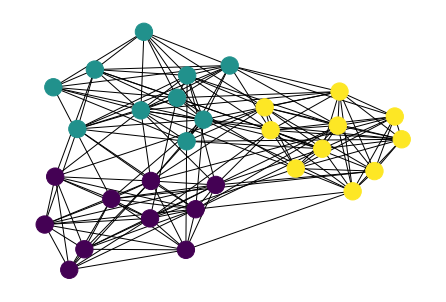

In [2]:
# Generate data using SBM model and assign node features
block_size = [10,10,10]
num_channels = 10 # dimension of features for each node
edge_probs = [[0.9,0.2,0.2], [0.2,0.9,0.2], [0.2,0.2,0.9]]
dataset= StochasticBlockModelDataset(root='SBM', block_sizes = block_size, num_channels=3, edge_probs = edge_probs)
data = dataset[0]
# Transform to adjacency matrix and compute Laplacian matrix for future use
A = to_dense_adj(data.edge_index).reshape(sum(block_size),sum(block_size)) # N*N
D = torch.sum(A, dim=1)
L = D-A
# Compute the minimum path length between two nodes for future use
G = to_networkx(data, to_undirected=True) 
dic = dict(nx.all_pairs_shortest_path_length(G))
dist = torch.zeros_like(A)
for i in range(dist.shape[0]):
    for j in range(dist.shape[1]):
        dist[i,j] = dic[i][j]
# Visualize the generated graph
nx.all_pairs_shortest_path_length(G)
nx.draw(G, node_color=data.y)

In [20]:
alpha = 100
lamda = 1
W, loss = CUR_torch_solver(data.x, L, alpha, lamda, method='Lap', epochs=1000, learning_rate=1e-1, print=False)
# Column sum
torch.max(W.abs(), dim=0).values 

tensor([2.3646e-04, 8.6267e-05, 2.5061e-04, 8.5464e-05, 6.3867e-05, 7.0378e-05,
        1.4492e-04, 8.6833e-05, 2.3920e-04, 1.0436e-04, 1.4047e-04, 2.7171e-04,
        1.9365e-04, 2.0350e-04, 1.6486e-04, 7.2218e-05, 3.1931e-04, 9.0671e-05,
        9.5102e-05, 2.1895e-04, 5.9472e-05, 2.7697e-04, 6.2412e-05, 1.6111e-04,
        1.6053e-04, 1.4728e-04, 2.5580e-04, 2.4165e-04, 5.8648e-05, 1.3074e-04],
       grad_fn=<MaxBackward0>)

In [3]:
alpha = 1
lamda = 1
W, loss = CUR_torch_solver(data.x, dist, alpha, lamda, method='dist', epochs=1000, learning_rate=1e-1, print=False)
torch.max(W.abs(), dim=0).values 

tensor([0.9314, 0.4278, 0.4542, 0.7735, 0.3398, 0.1708, 0.8995, 0.2552, 0.9497,
        0.4300, 0.9107, 0.8010, 0.6067, 0.1947, 0.6292, 0.2120, 0.8504, 0.1026,
        0.5866, 0.0406, 0.4583, 0.5636, 0.4820, 0.2848, 0.8947, 0.8712, 0.5926,
        0.2968, 0.2968, 0.8040], grad_fn=<MaxBackward0>)

In [4]:
epsilon = 0.01
W, W_tilde, W_hat, loss, rho_1, rho_2 = CUR_iter_solver(X=data.x, T=dist, alpha=alpha, lamda=lamda, epsilon=epsilon, initial_rho=1e-6, \
    max_rho=1e10, tau=1.1, set_seed=False)
torch.max(W.abs(), dim=0).values 

tensor([1.0215e-04, 3.5686e-05, 2.5318e-05, 5.0320e-05, 2.3294e-05, 2.3518e-05,
        6.5082e-05, 3.0146e-05, 9.5436e-05, 2.6761e-05, 7.9348e-05, 3.9964e-05,
        4.3782e-05, 2.4411e-05, 3.2025e-05, 2.9164e-05, 6.3476e-05, 1.8828e-05,
        4.0162e-05, 7.2578e-06, 2.4894e-05, 2.5981e-05, 2.5887e-05, 2.9048e-05,
        7.2146e-05, 5.8205e-05, 3.7072e-05, 2.1495e-05, 2.2625e-05, 4.7890e-05])

In [12]:
data.x

tensor([[-3.8261,  1.7098,  0.7902],
        [-1.0040, -1.4029, -1.0964],
        [-0.2770, -1.0288, -1.6590],
        [ 0.3455, -2.1791, -1.7952],
        [-1.2903, -0.5447, -1.0251],
        [ 0.9344, -0.3702, -0.9289],
        [ 0.0323,  1.1966, -3.1981],
        [ 1.4942,  0.1042, -0.7032],
        [ 2.2055,  3.4838, -0.0910],
        [ 1.4600,  0.4920,  1.0687],
        [-1.6550,  3.1802,  1.1393],
        [ 2.1727,  0.0289,  1.0199],
        [ 1.9466,  0.2457,  1.5225],
        [ 0.8098,  0.9481,  1.0360],
        [ 0.0433,  1.7637,  1.1356],
        [ 0.6849, -1.5875,  0.3549],
        [ 1.3841, -2.7872,  1.2841],
        [ 0.3402,  1.1025,  0.3172],
        [ 1.2634, -1.5373,  1.3332],
        [ 0.4264, -0.4453,  0.1508],
        [-0.1624, -1.2222,  1.2817],
        [-0.3510, -1.2623,  1.3240],
        [-0.8643, -1.0813,  1.0725],
        [-1.0360,  1.4488, -0.1774],
        [-2.8579,  0.8469, -1.9964],
        [-0.8593,  0.2583, -3.1020],
        [-0.3260,  2.2233, -0.4311],
 

In [15]:
sel = greedy_CSS(data.x.t(), k=2, c=None)
sel

tensor([18., 17.])